Total documents: 10
Boolean Retrieval Top 5 indices: []
TF-IDF Top 5 indices: [4 6 1 9 8]
BM25 Top 5 indices: [4 6 1 9 8]


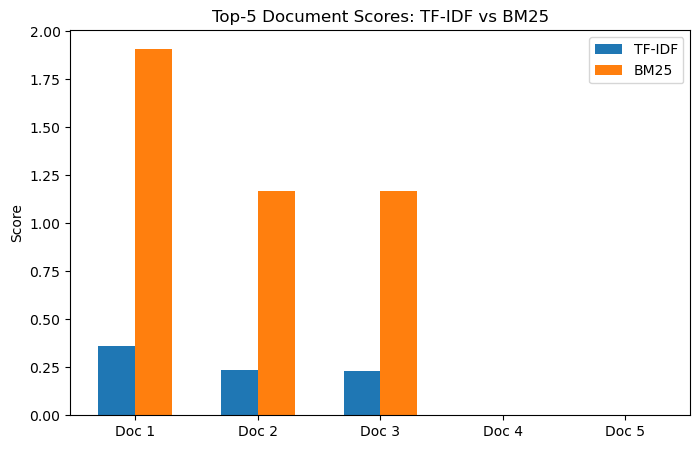

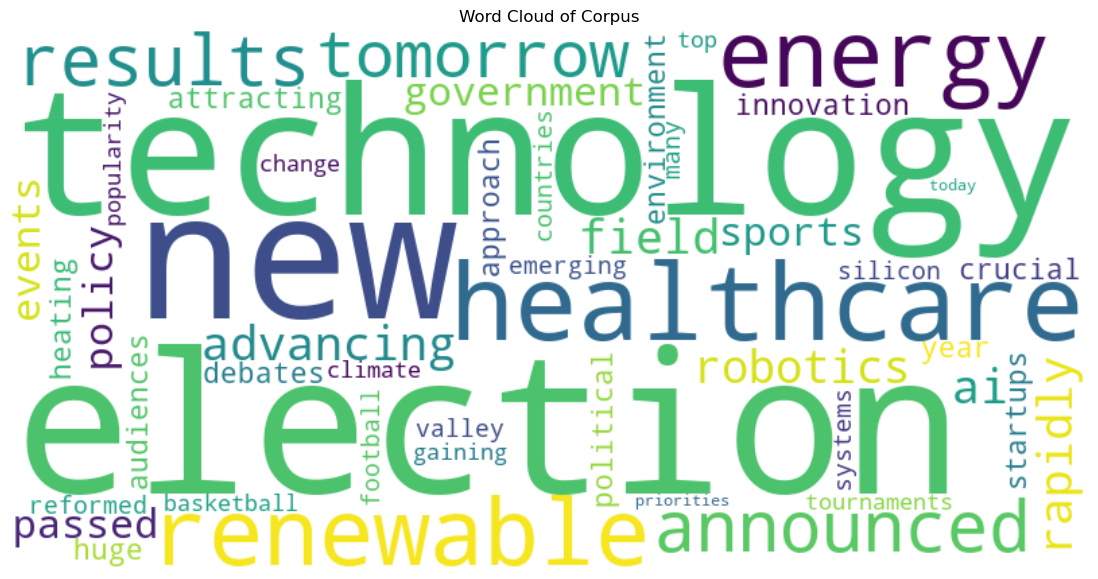

In [6]:
# IR_System.ipynb

# =============================
# CS 516: Information Retrieval and Text Mining
# Hybrid IR System: Boolean, TF-IDF, BM25
# =============================

# 1. Import Libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
import matplotlib.pyplot as plt

# Install WordCloud if missing
try:
    from wordcloud import WordCloud
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install wordcloud
    from wordcloud import WordCloud

# Suppress NLTK download logs
nltk.download('stopwords', quiet=True)

# =============================
# 2. Sample Dataset
# =============================
# Replace this with your CSV if available
data = {
    'content': [
        "The election results will be announced tomorrow.",
        "Technology is advancing rapidly in the field of AI and robotics.",
        "The government passed a new policy on healthcare.",
        "Sports events are attracting huge audiences this year.",
        "Innovation in renewable energy is crucial for the environment.",
        "Political debates are heating up as elections approach.",
        "New technology startups are emerging in Silicon Valley.",
        "Healthcare systems are being reformed in many countries.",
        "Football and basketball tournaments are gaining popularity.",
        "Climate change and renewable energy are top priorities today."
    ]
}

df = pd.DataFrame(data)
print(f'Total documents: {len(df)}')
df.head()

# =============================
# 3. Preprocessing
# =============================
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = str(text).lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

df['tokens'] = df['content'].apply(preprocess)
df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# =============================
# 4. Boolean Retrieval
# =============================
def boolean_retrieval(query, documents, operator='AND'):
    query_tokens = preprocess(query)
    results = []
    for idx, doc_tokens in enumerate(documents):
        doc_set = set(doc_tokens)
        if operator == 'AND':
            if all(token in doc_set for token in query_tokens):
                results.append(idx)
        elif operator == 'OR':
            if any(token in doc_set for token in query_tokens):
                results.append(idx)
        elif operator == 'NOT':
            if not any(token in doc_set for token in query_tokens):
                results.append(idx)
    return results[:5]

query1 = 'politics AND election'
boolean_results = boolean_retrieval('politics election', df['tokens'], operator='AND')
print('Boolean Retrieval Top 5 indices:', boolean_results)

# =============================
# 5. TF-IDF Retrieval
# =============================
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['processed_text'])

def tfidf_retrieval(query, tfidf_matrix, top_k=5):
    query_vec = vectorizer.transform([query])
    scores = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_indices = scores.argsort()[-top_k:][::-1]
    return top_indices, scores[top_indices]

query2 = 'technology innovation'
tfidf_indices, tfidf_scores = tfidf_retrieval(query2, tfidf_matrix)
print('TF-IDF Top 5 indices:', tfidf_indices)

# =============================
# 6. BM25 Retrieval
# =============================
documents_tokens = df['tokens'].tolist()
bm25 = BM25Okapi(documents_tokens)

def bm25_retrieval(query, bm25, top_k=5):
    query_tokens = preprocess(query)
    scores = bm25.get_scores(query_tokens)
    top_indices = np.argsort(scores)[-top_k:][::-1]
    return top_indices, scores[top_indices]

bm25_indices, bm25_scores = bm25_retrieval(query2, bm25)
print('BM25 Top 5 indices:', bm25_indices)

# =============================
# 7. Visualization
# =============================
# Top-5 scores comparison
plt.figure(figsize=(8,5))
x_labels = [f'Doc {i+1}' for i in range(5)]
plt.bar(np.arange(5)-0.15, tfidf_scores, width=0.3, label='TF-IDF')
plt.bar(np.arange(5)+0.15, bm25_scores, width=0.3, label='BM25')
plt.xticks(np.arange(5), x_labels)
plt.ylabel('Score')
plt.title('Top-5 Document Scores: TF-IDF vs BM25')
plt.legend()
plt.show()

# Word Cloud
all_text = ' '.join(df['processed_text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Corpus')
plt.show()
